### Step 1: Loading the Data

We begin by loading the training and testing data for both features (`X_train`, `X_test`) and target (`y_train`, `y_test`) from the processed CSV files. This is an essential step before starting the feature engineering process.

In [2]:
# Load the datasets for features and target
import pandas as pd

# Load training and testing features and target variables
X_train = pd.read_csv(r"../data/processed/X_train.csv")
X_test = pd.read_csv(r"../data/processed/X_test.csv")
y_train = pd.read_csv(r"../data/processed/y_train.csv")
y_test = pd.read_csv(r"../data/processed/y_test.csv")

# Display the first few rows of each dataset to inspect the data
print("X_train head:")
print(X_train.head())

print("X_test head:")
print(X_test.head())

print("y_train head:")
print(y_train.head())

print("y_test head:")
print(y_test.head())

X_train head:
          TransactionId         BatchId       AccountId       SubscriptionId  \
0  TransactionId_140210    BatchId_5730  AccountId_4841  SubscriptionId_3829   
1  TransactionId_121349    BatchId_3209  AccountId_1270  SubscriptionId_4526   
2  TransactionId_128133  BatchId_127344  AccountId_1796   SubscriptionId_913   
3   TransactionId_93768   BatchId_13153  AccountId_4841  SubscriptionId_3829   
4   TransactionId_36333   BatchId_15503  AccountId_2659  SubscriptionId_3327   

        CustomerId CurrencyCode  CountryCode    ProviderId     ProductId  \
0  CustomerId_4312          UGX          256  ProviderId_4   ProductId_6   
1  CustomerId_1632          UGX          256  ProviderId_6  ProductId_10   
2  CustomerId_2186          UGX          256  ProviderId_6   ProductId_3   
3  CustomerId_3876          UGX          256  ProviderId_4   ProductId_6   
4  CustomerId_3078          UGX          256  ProviderId_6  ProductId_10   

      ProductCategory    ChannelId   Amount  Val

Create Aggregate Features

In [3]:

# Ensure that 'Amount' is a numeric column (in case there are any non-numeric values)
X_train['Amount'] = pd.to_numeric(X_train['Amount'], errors='coerce')

# Creating aggregate features for training data
X_train['Total_Transaction_Amount'] = X_train.groupby('CustomerId')['Amount'].transform('sum')
X_train['Average_Transaction_Amount'] = X_train.groupby('CustomerId')['Amount'].transform('mean')
X_train['Transaction_Count'] = X_train.groupby('CustomerId')['TransactionId'].transform('count')
X_train['Transaction_Amount_Std'] = X_train.groupby('CustomerId')['Amount'].transform('std')

# Display the updated dataframe with the new features
print(X_train[['CustomerId', 'Total_Transaction_Amount', 'Average_Transaction_Amount', 'Transaction_Count', 'Transaction_Amount_Std']].head())

        CustomerId  Total_Transaction_Amount  Average_Transaction_Amount  \
0  CustomerId_4312                 154430.00                 1575.816327   
1  CustomerId_1632                 263950.00                 5075.961538   
2  CustomerId_2186                 158189.65                 2002.400633   
3  CustomerId_3876                 422951.00                 1395.877888   
4  CustomerId_3078                1932970.00                 4324.317673   

   Transaction_Count  Transaction_Amount_Std  
0                 98             2552.127644  
1                 52             5925.489062  
2                 79             3374.720534  
3                303             3743.970559  
4                447            23581.283142  


Extracting Time-Based Features

In this step, we extract several time-based features from the `TransactionStartTime` column:
- **Transaction Hour**: The hour of the day when the transaction occurred. This can capture patterns like morning or evening transactions.
- **Transaction Day**: The day of the month when the transaction occurred, helping to capture any patterns related to specific dates.
- **Transaction Month**: The month when the transaction occurred. This feature helps identify seasonal trends or specific months with higher transaction activity.
- **Transaction Year**: The year when the transaction took place, which might capture year-over-year trends.

These features will help the model understand the temporal patterns in the data.


In [4]:
# Ensure that 'TransactionStartTime' is in datetime format
X_train['TransactionStartTime'] = pd.to_datetime(X_train['TransactionStartTime'], errors='coerce')

# Extract time-based features
X_train['Transaction_Hour'] = X_train['TransactionStartTime'].dt.hour
X_train['Transaction_Day'] = X_train['TransactionStartTime'].dt.day
X_train['Transaction_Month'] = X_train['TransactionStartTime'].dt.month
X_train['Transaction_Year'] = X_train['TransactionStartTime'].dt.year

# Display the updated dataframe with the new time-based features
print(X_train[['CustomerId', 'Transaction_Hour', 'Transaction_Day', 'Transaction_Month', 'Transaction_Year']].head())

        CustomerId  Transaction_Hour  Transaction_Day  Transaction_Month  \
0  CustomerId_4312                 8               13                  1   
1  CustomerId_1632                16               21                 12   
2  CustomerId_2186                18               23                  1   
3  CustomerId_3876                11               12                  1   
4  CustomerId_3078                 7                8                  2   

   Transaction_Year  
0              2019  
1              2018  
2              2019  
3              2019  
4              2019  


Encode Categorical Variables

In this step, we apply **One-Hot Encoding** to categorical variables like `CurrencyCode`, `ProviderId`, `ProductId`, `ProductCategory`, and `ChannelId`. These variables are non-numerical, and One-Hot Encoding transforms them into binary columns, allowing the machine learning model to interpret them correctly.

After encoding, we drop the first column in each variable to avoid multicollinearity (where one column can be predicted by others, which can distort the model).

The encoding will result in new columns in the dataset, making it ready for machine learning models.


In [5]:
# List of categorical columns to encode
categorical_columns = ['CurrencyCode', 'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId']

# Apply One-Hot Encoding
X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True)

# Display the updated dataframe with encoded categorical variables
print(X_train_encoded.head())

          TransactionId         BatchId       AccountId       SubscriptionId  \
0  TransactionId_140210    BatchId_5730  AccountId_4841  SubscriptionId_3829   
1  TransactionId_121349    BatchId_3209  AccountId_1270  SubscriptionId_4526   
2  TransactionId_128133  BatchId_127344  AccountId_1796   SubscriptionId_913   
3   TransactionId_93768   BatchId_13153  AccountId_4841  SubscriptionId_3829   
4   TransactionId_36333   BatchId_15503  AccountId_2659  SubscriptionId_3327   

        CustomerId  CountryCode   Amount  Value      TransactionStartTime  \
0  CustomerId_4312          256   -100.0    100 2019-01-13 08:21:54+00:00   
1  CustomerId_1632          256   5000.0   5000 2018-12-21 16:18:15+00:00   
2  CustomerId_2186          256   1000.0   1000 2019-01-23 18:29:27+00:00   
3  CustomerId_3876          256    -70.0     70 2019-01-12 11:14:03+00:00   
4  CustomerId_3078          256  20000.0  20000 2019-02-08 07:10:12+00:00   

   PricingStrategy  ...  ProductCategory_financial_servi

Standardize Numerical Features

Standardizing numerical features is important for algorithms that are sensitive to the scale of data (e.g., KNN, SVM). In this step, we standardize the numerical columns so that they have a mean of 0 and a standard deviation of 1. 

We use the `StandardScaler` from `sklearn` to achieve this.

The transformation is applied only to the numerical features in the dataset, and after applying standardization, we verify the result by inspecting the first few rows.


In [6]:
from sklearn.preprocessing import StandardScaler

# Standardize numerical features
scaler = StandardScaler()

# List of numerical columns
numerical_columns = X_train_encoded.select_dtypes(include=["float64", "int64"]).columns

# Apply standardization to numerical columns
X_train_encoded[numerical_columns] = scaler.fit_transform(X_train_encoded[numerical_columns])

# Check the standardized data
print(X_train_encoded[numerical_columns].head())

   CountryCode    Amount     Value  PricingStrategy  Total_Transaction_Amount  \
0          0.0 -0.056453 -0.080693         -0.34828                  0.171150   
1          0.0 -0.015089 -0.040890         -0.34828                  0.177455   
2          0.0 -0.047531 -0.073382         -0.34828                  0.171367   
3          0.0 -0.056209 -0.080937         -0.34828                  0.186609   
4          0.0  0.106567  0.080956         -0.34828                  0.273544   

   Average_Transaction_Amount  Transaction_Count  Transaction_Amount_Std  
0                   -0.065951          -0.308880               -0.163579  
1                   -0.022270          -0.374590               -0.128134  
2                   -0.060627          -0.336021               -0.154936  
3                   -0.068196          -0.016044               -0.151056  
4                   -0.031651           0.189655                0.057382  


In [7]:
# Handling outliers by clipping values within the bounds for 'Amount' and 'Value'
X_train_encoded['Amount'] = X_train_encoded['Amount'].clip(lower=-4325.0, upper=7075.0)
X_train_encoded['Value'] = X_train_encoded['Value'].clip(lower=-6812.5, upper=12087.5)

# Check the first few rows after clipping
print(X_train_encoded[['Amount', 'Value']].head())

     Amount     Value
0 -0.056453 -0.080693
1 -0.015089 -0.040890
2 -0.047531 -0.073382
3 -0.056209 -0.080937
4  0.106567  0.080956


In [8]:
# Handling outliers in 'PricingStrategy' by replacing outlier values with the mode (most frequent value)
X_train_encoded['PricingStrategy'] = X_train_encoded['PricingStrategy'].replace([1, 4], 2)

# Check the first few rows after replacing outliers
print(X_train_encoded['PricingStrategy'].head())

0   -0.34828
1   -0.34828
2   -0.34828
3   -0.34828
4   -0.34828
Name: PricingStrategy, dtype: float64


Handle Outliers

Outliers can significantly affect machine learning models, leading to incorrect predictions or poor model performance. We have detected outliers in the following columns:

1. **Amount**: We clipped values to the range of [-4325.0, 7075.0].
2. **Value**: We clipped values to the range of [-6812.5, 12087.5].
3. **PricingStrategy**: We replaced outlier values (1 and 4) with the most frequent value, which is 2.
4. **FraudResult**: Since this is a binary column, we don’t need to handle outliers.

We use **clipping** to handle the outliers in `Amount` and `Value`, and **replacement** for the `PricingStrategy` column.

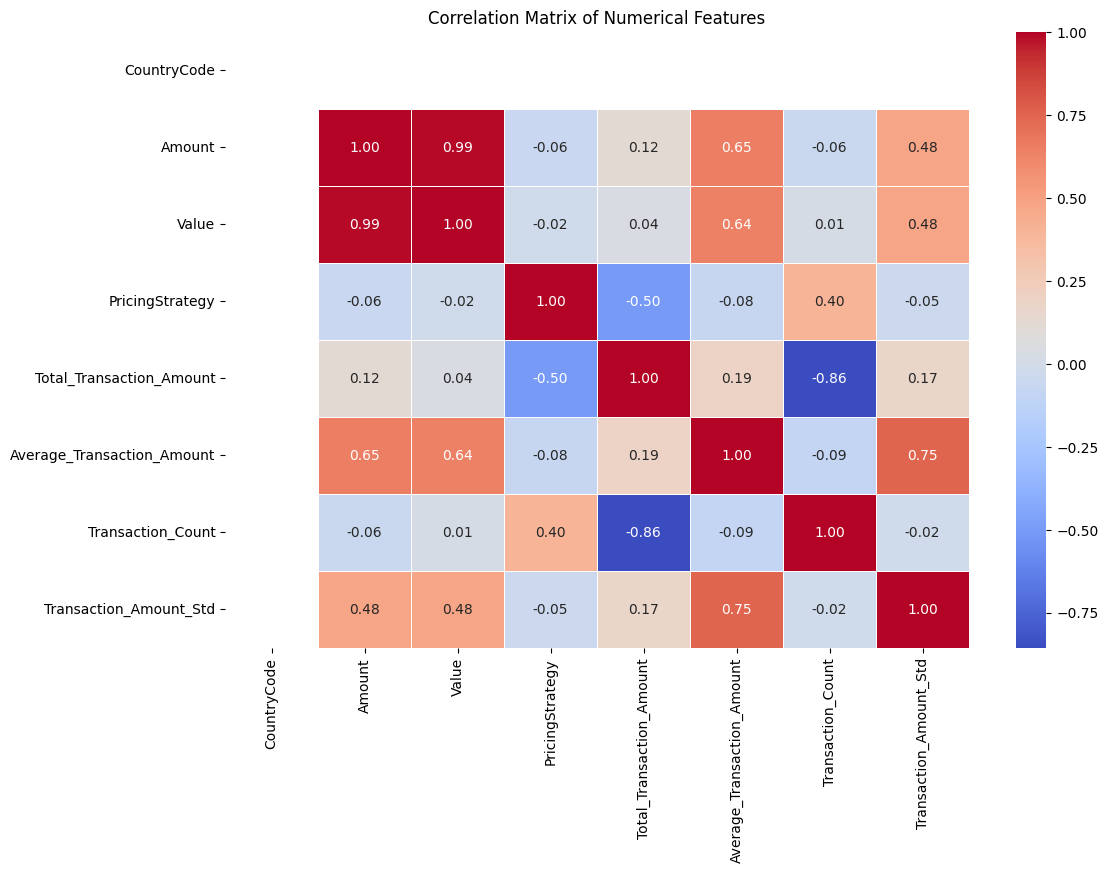

                            CountryCode    Amount     Value  PricingStrategy  \
CountryCode                         NaN       NaN       NaN              NaN   
Amount                              NaN  1.000000  0.990110        -0.063581   
Value                               NaN  0.990110  1.000000        -0.018924   
PricingStrategy                     NaN -0.063581 -0.018924         1.000000   
Total_Transaction_Amount            NaN  0.122482  0.042154        -0.501874   
Average_Transaction_Amount          NaN  0.649894  0.639097        -0.075507   
Transaction_Count                   NaN -0.057628  0.013767         0.404887   
Transaction_Amount_Std              NaN  0.480540  0.483495        -0.049208   

                            Total_Transaction_Amount  \
CountryCode                                      NaN   
Amount                                      0.122482   
Value                                       0.042154   
PricingStrategy                            -0.501874   

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
# Select only numerical columns for correlation analysis
numerical_columns = X_train_encoded.select_dtypes(include=['float64', 'int64']).columns

# Filter the dataframe to only include numerical columns
X_train_numeric = X_train_encoded[numerical_columns]

# Compute the correlation matrix for the selected numerical features
correlation_matrix = X_train_numeric.corr()

# Display the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Optionally, print the correlation matrix as well
print(correlation_matrix)

Feature Selection
Feature selection is the process of selecting a subset of the most relevant features for model training. In our case, the Value column is the absolute value of Amount and doesn't provide additional information. Removing such redundant features can help the model perform better and reduce overfitting.

Remove Redundant Features: We will drop the Value column, which is highly correlated with Amount, as it does not contribute new information to the model.
Feature Correlation: We also consider dropping features that are highly correlated (e.g., Amount and Value).

In [11]:
# Feature selection: Drop the 'Value' column as it's the absolute value of 'Amount'
X_train_selected = X_train.drop(columns=['Value'])

# Checking the updated dataset after dropping the 'Value' column
X_train_selected.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,...,TransactionStartTime,PricingStrategy,Total_Transaction_Amount,Average_Transaction_Amount,Transaction_Count,Transaction_Amount_Std,Transaction_Hour,Transaction_Day,Transaction_Month,Transaction_Year
0,TransactionId_140210,BatchId_5730,AccountId_4841,SubscriptionId_3829,CustomerId_4312,UGX,256,ProviderId_4,ProductId_6,financial_services,...,2019-01-13 08:21:54+00:00,2,154430.00,1575.816327,98,2552.127644,8,13,1,2019
1,TransactionId_121349,BatchId_3209,AccountId_1270,SubscriptionId_4526,CustomerId_1632,UGX,256,ProviderId_6,ProductId_10,airtime,...,2018-12-21 16:18:15+00:00,2,263950.00,5075.961538,52,5925.489062,16,21,12,2018
2,TransactionId_128133,BatchId_127344,AccountId_1796,SubscriptionId_913,CustomerId_2186,UGX,256,ProviderId_6,ProductId_3,airtime,...,2019-01-23 18:29:27+00:00,2,158189.65,2002.400633,79,3374.720534,18,23,1,2019
3,TransactionId_93768,BatchId_13153,AccountId_4841,SubscriptionId_3829,CustomerId_3876,UGX,256,ProviderId_4,ProductId_6,financial_services,...,2019-01-12 11:14:03+00:00,2,422951.00,1395.877888,303,3743.970559,11,12,1,2019
4,TransactionId_36333,BatchId_15503,AccountId_2659,SubscriptionId_3327,CustomerId_3078,UGX,256,ProviderId_6,ProductId_10,airtime,...,2019-02-08 07:10:12+00:00,2,1932970.00,4324.317673,447,23581.283142,7,8,2,2019


In [12]:
# Applying the same selection to the test set (drop 'Value' from X_test)
X_test_selected = X_test.drop(columns=['Value'])

# Checking the updated test dataset
X_test_selected.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,TransactionStartTime,PricingStrategy
0,TransactionId_121021,BatchId_65374,AccountId_2467,SubscriptionId_301,CustomerId_2883,UGX,256,ProviderId_1,ProductId_3,airtime,ChannelId_3,500.0,2019-02-08 09:24:16+00:00,4
1,TransactionId_36418,BatchId_80071,AccountId_3600,SubscriptionId_3127,CustomerId_4038,UGX,256,ProviderId_6,ProductId_11,data_bundles,ChannelId_3,2000.0,2019-01-14 19:27:56+00:00,2
2,TransactionId_43176,BatchId_120172,AccountId_1148,SubscriptionId_3645,CustomerId_1505,UGX,256,ProviderId_6,ProductId_19,tv,ChannelId_3,3000.0,2019-01-14 08:43:44+00:00,2
3,TransactionId_9264,BatchId_134493,AccountId_640,SubscriptionId_972,CustomerId_979,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,5000.0,2018-12-28 10:40:49+00:00,2
4,TransactionId_43604,BatchId_126927,AccountId_4104,SubscriptionId_28,CustomerId_4555,UGX,256,ProviderId_1,ProductId_15,financial_services,ChannelId_3,10000.0,2019-01-25 11:25:54+00:00,2


In [13]:
# Save the final processed X_train to a CSV file
X_train.to_csv('../data/processed/X_train_processed.csv', index=False)

In [2]:
# Import necessary libraries
import pandas as pd

# Load the x_test dataset (replace with the actual path to your test data)
x_test = pd.read_csv('../data/processed/x_test.csv')

# Ensure the 'TransactionStartTime' column is in datetime format
x_test['TransactionStartTime'] = pd.to_datetime(x_test['TransactionStartTime'])

# Check for any missing values in the dataframe (optional)
print(x_test.isnull().sum())

TransactionId           0
BatchId                 0
AccountId               0
SubscriptionId          0
CustomerId              0
CurrencyCode            0
CountryCode             0
ProviderId              0
ProductId               0
ProductCategory         0
ChannelId               0
Amount                  0
Value                   0
TransactionStartTime    0
PricingStrategy         0
dtype: int64


In [3]:
# List of categorical columns to encode (the same columns as used for x_train)
categorical_columns = ['CurrencyCode', 'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId']

# Apply One-Hot Encoding to the x_test dataframe
x_test_encoded = pd.get_dummies(x_test, columns=categorical_columns, drop_first=True)

# Display the updated dataframe with encoded categorical variables
print(x_test_encoded.head())

          TransactionId         BatchId       AccountId       SubscriptionId  \
0  TransactionId_121021   BatchId_65374  AccountId_2467   SubscriptionId_301   
1   TransactionId_36418   BatchId_80071  AccountId_3600  SubscriptionId_3127   
2   TransactionId_43176  BatchId_120172  AccountId_1148  SubscriptionId_3645   
3    TransactionId_9264  BatchId_134493   AccountId_640   SubscriptionId_972   
4   TransactionId_43604  BatchId_126927  AccountId_4104    SubscriptionId_28   

        CustomerId  CountryCode   Amount  Value      TransactionStartTime  \
0  CustomerId_2883          256    500.0    500 2019-02-08 09:24:16+00:00   
1  CustomerId_4038          256   2000.0   2000 2019-01-14 19:27:56+00:00   
2  CustomerId_1505          256   3000.0   3000 2019-01-14 08:43:44+00:00   
3   CustomerId_979          256   5000.0   5000 2018-12-28 10:40:49+00:00   
4  CustomerId_4555          256  10000.0  10000 2019-01-25 11:25:54+00:00   

   PricingStrategy  ...  ProductCategory_data_bundles  \

In [10]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the raw data for x_train and x_test
x_train = pd.read_csv(r"../data/processed/X_train.csv")
x_test = pd.read_csv(r"../data/processed/X_test.csv")

# List of categorical columns to encode
categorical_columns = ['CurrencyCode', 'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId']

# Apply One-Hot Encoding to X_train
X_train_encoded = pd.get_dummies(x_train, columns=categorical_columns, drop_first=True)

# Apply One-Hot Encoding to x_test (Ensure consistency between train and test)
x_test_encoded = pd.get_dummies(x_test, columns=categorical_columns, drop_first=True)

# Ensure the columns match between X_train_encoded and x_test_encoded
x_test_encoded = x_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Now, apply standardization using StandardScaler
scaler = StandardScaler()

# List of numerical columns (you can choose specific columns if needed)
numerical_columns = X_train_encoded.select_dtypes(include=["float64", "int64"]).columns

# Standardize numerical columns in X_train
X_train_encoded[numerical_columns] = scaler.fit_transform(X_train_encoded[numerical_columns])

# Standardize the same numerical columns in x_test using the already fitted scaler
x_test_encoded[numerical_columns] = scaler.transform(x_test_encoded[numerical_columns])

# Check the standardized data in both datasets
print("Standardized X_train:")
print(X_train_encoded[numerical_columns].head())
print("\nStandardized x_test:")
print(x_test_encoded[numerical_columns].head())


Standardized X_train:
   CountryCode    Amount     Value  PricingStrategy
0          0.0 -0.056453 -0.080693         -0.34828
1          0.0 -0.015089 -0.040890         -0.34828
2          0.0 -0.047531 -0.073382         -0.34828
3          0.0 -0.056209 -0.080937         -0.34828
4          0.0  0.106567  0.080956         -0.34828

Standardized x_test:
   CountryCode    Amount     Value  PricingStrategy
0          0.0 -0.051586 -0.077444         2.380937
1          0.0 -0.039421 -0.065259        -0.348280
2          0.0 -0.031310 -0.057136        -0.348280
3          0.0 -0.015089 -0.040890        -0.348280
4          0.0  0.025463 -0.000275        -0.348280


In [11]:
# Handling outliers by clipping values within the bounds for 'Amount' and 'Value' in x_test_encoded
x_test_encoded['Amount'] = x_test_encoded['Amount'].clip(lower=-4325.0, upper=7075.0)
x_test_encoded['Value'] = x_test_encoded['Value'].clip(lower=-6812.5, upper=12087.5)

# Check the first few rows after clipping in x_test_encoded
print("x_test_encoded after clipping:")
print(x_test_encoded[['Amount', 'Value']].head())

x_test_encoded after clipping:
     Amount     Value
0 -0.051586 -0.077444
1 -0.039421 -0.065259
2 -0.031310 -0.057136
3 -0.015089 -0.040890
4  0.025463 -0.000275


In [12]:
# Handling outliers in 'PricingStrategy' by replacing outlier values with the mode (most frequent value) in x_test_encoded
x_test_encoded['PricingStrategy'] = x_test_encoded['PricingStrategy'].replace([1, 4], 2)

# Check the first few rows after replacing outliers in x_test_encoded
print("x_test_encoded 'PricingStrategy' after handling outliers:")
print(x_test_encoded['PricingStrategy'].head())

x_test_encoded 'PricingStrategy' after handling outliers:
0    2.380937
1   -0.348280
2   -0.348280
3   -0.348280
4   -0.348280
Name: PricingStrategy, dtype: float64


In [13]:
# Save the processed x_test_encoded dataframe to a CSV file
x_test_encoded.to_csv('../data/processed/x_test_processed.csv', index=False)

# Confirm the file has been saved
print("x_test_encoded has been saved as 'x_test_processed.csv'")

x_test_encoded has been saved as 'x_test_processed.csv'
